In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Subir dos niveles desde blog/notebooks/ hasta data/
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.insert(0, project_root)

from database.connection import get_db_manager

In [2]:
# Configuration
TABLE_TYPE = 'domestic'
LEAGUES = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']
SEASON = '2425'
MIN_MINUTES = 800

# Team colors
BARCELONA_COLORS = {
    'primary': '#A50044',
    'secondary': '#004D98'
}

LAZIO_COLORS = {
    'primary': '#87CEEB',
    'secondary': '#FFFFFF'
}

# Players
DF_PLAYERS = [
    {'name': 'Iñigo Martínez', 'search': 'Iñigo Martínez|Inigo Martinez', 'pos': 'DF', 'team': 'Barcelona'},
    {'name': 'Mario Gila', 'search': 'Mario Gila|Gila', 'pos': 'DF', 'team': 'Lazio'},
]

SAVE_PATH_BASE = "./inigo_vs_gila_radars/"
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [3]:
# Database connection
db = get_db_manager()

league_list_str = "', '".join(LEAGUES)
query = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_{TABLE_TYPE} p
WHERE p.league IN ('{league_list_str}')
AND p.season = '{SEASON}'
ORDER BY p.league, p.season DESC, p.team, p.player_name
"""

df_raw = pd.read_sql(query, db.engine)
db.close()

print(f"Extraídos: {df_raw.shape[0]} registros")

2026-01-26 09:50:48,407 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-26 09:50:48,782 - database.connection - INFO - Database connection successful


Extraídos: 2722 registros


In [4]:
# Filter by minutes and position DF
df_filtered = df_raw[
    (df_raw['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES) &
    (df_raw['position'].str.contains('DF', case=False, na=False))
].copy()

print(f"Filtro {MIN_MINUTES}+ min + DF: {df_filtered.shape[0]} jugadores")

Filtro 800+ min + DF: 680 jugadores


In [5]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    if value is None or pd.isna(value):
        return np.nan
    if isinstance(value, str):
        if value.strip() == '' or value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    return np.nan

fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
understat_nums = extract_metrics(df_filtered, 'understat_metrics')
print(f"FBref: {fbref_nums.shape[1]} métricas | Understat: {understat_nums.shape[1]} métricas")

FBref: 185 métricas | Understat: 10 métricas


In [6]:
# Metrics to exclude from normalization
exclude_normalization = {
    'minutes_played', 'age', 'birth_year', 'games_started', 'minutes_per_game',
    'minutes_per_start', 'games', 'games_subs', 'unused_sub', 'points_per_game',
    'on_goals_for', 'on_goals_against', 'plus_minus', 'plus_minus_per90',
    'plus_minus_wowy', 'on_xg_for', 'on_xg_against', 'xg_plus_minus',
    'xg_plus_minus_per90', 'xg_plus_minus_wowy', 'Touches_Touches',
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%'
}

# Per100touches FBref
fbref_per100 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_normalization)]
fbref_per100 = (fbref_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
fbref_per100.columns = [f'{col}_per100touches' for col in fbref_per100.columns]

# Per100touches Understat
understat_per100 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_normalization)]
understat_per100 = (understat_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
understat_per100.columns = [f'{col}_per100touches' for col in understat_per100.columns]

print(f"Per100touches: {fbref_per100.shape[1]} + {understat_per100.shape[1]}")

# Combine all metrics
all_metrics = pd.concat([fbref_nums, understat_nums, fbref_per100, understat_per100], axis=1)

Per100touches: 174 + 10


In [7]:
# Calculate percentiles
all_percentiles = all_metrics.rank(pct=True) * 98 + 1
all_percentiles = all_percentiles.round(0).astype('Int64')
all_percentiles.columns = [f'{col}_pct' for col in all_percentiles.columns]

# Final consolidated DataFrame
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']

df_final = pd.concat([
    df_filtered[base_cols],
    all_metrics,
    all_percentiles
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")

DataFrame final: 680 filas, 764 columnas


In [8]:
# Search players
player_ids = {}

print("PLAYER SEARCH:")
print("=" * 50)

for player_config in DF_PLAYERS:
    player_name = player_config['name']
    search_pattern = player_config['search']
    
    search_results = df_filtered[
        df_filtered['player_name'].str.contains(search_pattern, case=False, na=False)
    ]
    
    if len(search_results) > 0:
        print(f"\n{player_name} - search: '{search_pattern}':")
        for _, p in search_results.iterrows():
            minutes = p['fbref_metrics'].get('minutes_played', 0) if isinstance(p['fbref_metrics'], dict) else 0
            print(f"  {p['unique_player_id']} - {p['player_name']} ({p['team']}, {p['league']}) - {minutes} min")
            
            if player_name not in player_ids:
                player_ids[player_name] = p['unique_player_id']
                print(f"  ✓ ASSIGNED")
                break
    else:
        print(f"\n{player_name}: NOT FOUND")

print("\n" + "=" * 50)
print("PLAYERS FOUND:")
for name, player_id in player_ids.items():
    print(f"  {name}: {player_id}")

PLAYER SEARCH:

Iñigo Martínez - search: 'Iñigo Martínez|Inigo Martinez':
  63ab52f210f142e9 - Iñigo Martínez (Barcelona, ESP-La Liga) - 2490.0 min
  ✓ ASSIGNED

Mario Gila - search: 'Mario Gila|Gila':
  d06b2845073ff714 - Mario Gila (Lazio, ITA-Serie A) - 2741.0 min
  ✓ ASSIGNED

PLAYERS FOUND:
  Iñigo Martínez: 63ab52f210f142e9
  Mario Gila: d06b2845073ff714


In [9]:
# CB metrics configuration (10 metrics)
df_metrics = [
    'pass_completion_pct', 'Challenges_Tkl%', 'Aerial Duels_Won_per100touches', 'Aerial Duels_Won%',
    'passes_final_third_per100touches', 'clearances_per100touches', 'progressive_passes_per100touches', 'Tkl+Int_per100touches',
    'interceptions_per100touches', 'Blocks_Sh_per100touches'
]
df_titles = [
    'Pass Accuracy %', 'Tackle Success %', 'Aerial Duels Won', 'Aerial Success %',
    'Final Third Passes', 'Clearances', 'Progressive Passes', 'Tackles + Interceptions',
    'Interceptions', 'Shot Blocks'
]

print(f"CB Metrics: {len(df_metrics)} metrics, {len(df_titles)} titles")

CB Metrics: 10 metrics, 10 titles


In [10]:
# Comparison configuration
COMPARISON = {
    'name': 'Inigo_Martinez_vs_Gila',
    'player1': 'Iñigo Martínez',
    'player2': 'Mario Gila', 
    'title': 'Iñigo Martínez vs Mario Gila (24/25)',
    'faces': ['../../blog/caras/iñigo.png', '../../blog/caras/gila.png'],
    'colors': [BARCELONA_COLORS['primary'], LAZIO_COLORS['primary']]
}

print(f"COMPARISON: {COMPARISON['title']}")
print(f"Colors: {COMPARISON['colors']}")

COMPARISON: Iñigo Martínez vs Mario Gila (24/25)
Colors: ['#A50044', '#87CEEB']


RADAR GENERATION

Processing: Iñigo Martínez vs Mario Gila (24/25)
  Dataset: 625 players (DF)
  Teams: Barcelona vs Lazio
  Colors: ['#A50044', '#87CEEB']
  ✓ Completed: Inigo_Martinez_vs_Gila_combined.png


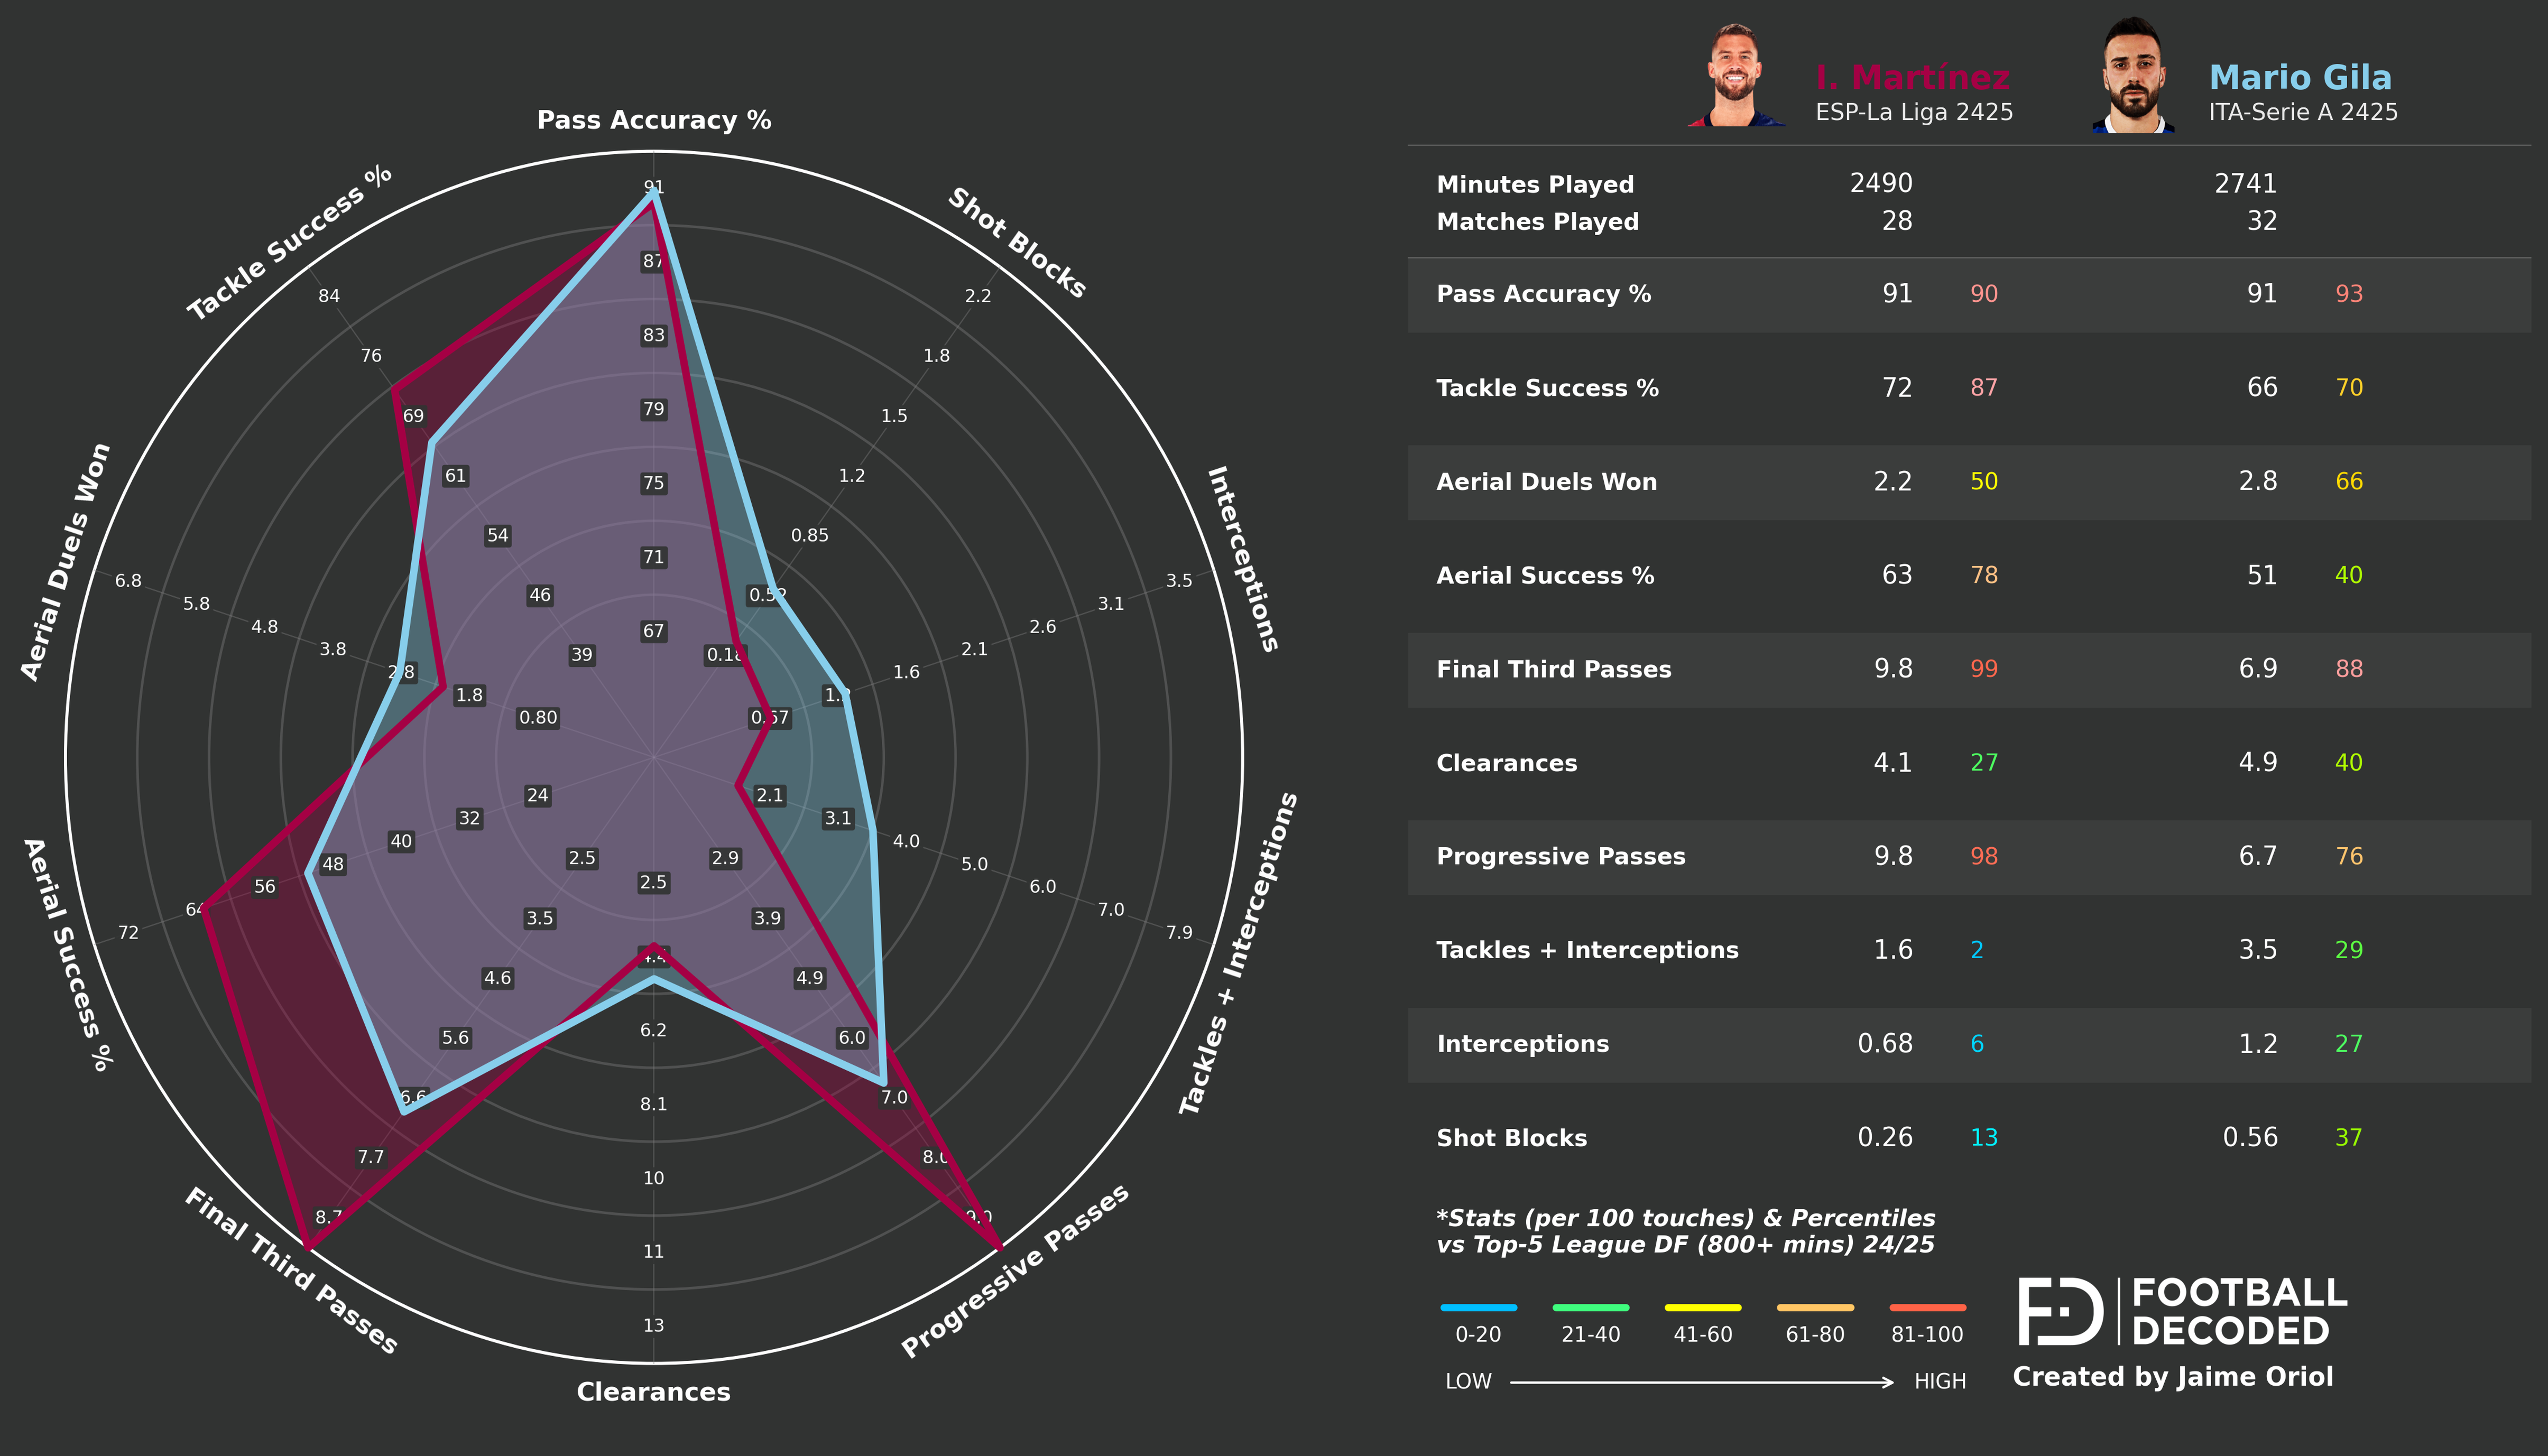

In [11]:
from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

print("RADAR GENERATION")
print("=" * 50)

comparison = COMPARISON
config_name = comparison['name']
player1_name = comparison['player1'] 
player2_name = comparison['player2']
title = comparison['title']
faces = comparison['faces']
colors = comparison['colors']

print(f"\nProcessing: {title}")

if player1_name not in player_ids or player2_name not in player_ids:
    print(f"Missing player ID")
    print(f"  {player1_name}: {'Found' if player1_name in player_ids else 'Missing'}")
    print(f"  {player2_name}: {'Found' if player2_name in player_ids else 'Missing'}")
else:
    player1_id = player_ids[player1_name]
    player2_id = player_ids[player2_name]
    
    # Dataset DF
    position_df = df_final[df_final['position'].str.startswith('DF')].copy()
    position_filter = "DF"
    
    print(f"  Dataset: {position_df.shape[0]} players ({position_filter})")
    
    # Team names
    player1_team = df_final.loc[df_final['unique_player_id'] == player1_id, 'team'].iloc[0]
    player2_team = df_final.loc[df_final['unique_player_id'] == player2_id, 'team'].iloc[0]
    
    team_colors = colors
    team_logos = {}
    if faces[0]:
        team_logos[player1_team] = faces[0]
    if len(faces) > 1 and faces[1]:
        team_logos[player2_team] = faces[1]
    
    print(f"  Teams: {player1_team} vs {player2_team}")
    print(f"  Colors: {colors}")
    
    try:
        create_player_radar(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=df_metrics,
            metric_titles=df_titles,
            team_colors=team_colors,
            save_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        create_stats_table(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=df_metrics,
            metric_titles=df_titles,
            team_colors=team_colors,
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}{config_name}_table.png",
            footer_text=f"Stats (per 100 touches) & Percentiles\nvs Top-5 League {position_filter} ({MIN_MINUTES}+ mins) 24/25",
            show_plot=False
        )
        
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            table_path=f"{SAVE_PATH_BASE}{config_name}_table.png", 
            output_path=f"{SAVE_PATH_BASE}{config_name}_combined.png"
        )
        
        print(f"  ✓ Completed: {config_name}_combined.png")
        
        display(IPImage(f"{SAVE_PATH_BASE}{config_name}_combined.png"))
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        import traceback
        traceback.print_exc()